In [6]:
def reward_function(label, pred, default_pred):
    if label == 1:
        return -(abs(pred - 1) - abs(default_pred - 1))
    elif label == 0:
        return -(abs(pred - 0) - abs(default_pred - 0))
    else:
        raise ValueError("label must be 0 or 1")

In [7]:
# 示例数据
label = 1
default_pred = 0.6
pred = 1

# 计算奖励
reward = reward_function(label, pred, default_pred)
print(f"Reward: {reward}")

Reward: 0.4


In [8]:
a=[-31.63854784965515,-31.178343069553375,-32.09305536746979,-28.6159308552742,-31.094459116458893,-29.057870078086854,-30.282761061191557,-30.586018139123915,-27.409115648269655,-25.787958645820616,-28.932888197898865,-30.04615526199341,-30.44692482948303,-29.180044889450073,-27.466085886955263,-14.759451135993004,-0.8202175855636596,0.800502547621727,2.9948579609394073,1.8222450494766236,1.6935297816991806,2.146632620692253,2.347743898630142,1.3298047184944153,0.21709657460451126,-1.783453631401062,-2.030194430053234,-0.048105749487876895,0.36996065080165863,-0.7122411400079727,0.9505878299474716,-0.11259048581123351,-0.11909081637859345,0.4172153174877167,-1.395151999592781,0.31974995136260986,1.7152358084917068,0.7387758731842041,0.2687603920698166,-0.06033065915107727,1.4519851207733154,0.346883624792099,1.72181293964386,1.7281776249408722,2.992855739593506,4.700093138217926,2.3348742365837096,2.4588230162858964,2.2957314640283584,2.1002505898475645,0.2643387705087662,2.931847357749939,1.9232045352458953,2.3403399020433424,4.048990792036056,1.8947390258312224,2.6039832681417465,1.2424537807703018,1.2194243937730789,1.0190766036510468,2.389182388782501,2.2810485005378722,1.3280761629343032,4.092987525463104,2.6094721481204033,4.433287346363068,2.2175348848104477,-1.5904832392930985,2.517060619592667,3.885602408647537,2.8100075513124465,4.001980727910995,0.5821167796850204,2.705909329652786,1.3574491918087006,3.27655867934227,2.1157252848148347,3.2321499586105347,5.072263038158416,1.8942615315318108,0.8369774997234345,2.6163575112819673,3.131375381350517,2.820387291908264,0.9971843212842941,2.4607914596796037,1.3171908259391785,2.550902098417282,3.3329617202281954,3.132740116119385,2.787603425979614,0.913312166929245,2.426340389251709,2.667362755537033,0.6292018920183182,3.067597246170044,1.8352360993623733,2.8139697939157484,2.169678807258606,4.48994402885437,2.7732338666915894,4.2178016528487206,3.2967188596725463,3.905336561799049,1.2191088140010833,2.8243406057357787,3.28622567653656,3.434660205245018,2.14436457157135,1.4412387490272522,3.6175274342298507,3.0758949398994444,3.13944326043129,4.100712326169014,1.7563680171966554,4.65304548740387]

In [9]:
import matplotlib.pyplot as plt

plt.plot(range(len(a)), a)

Error in callback <function flush_figures at 0x7ff399b91af0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

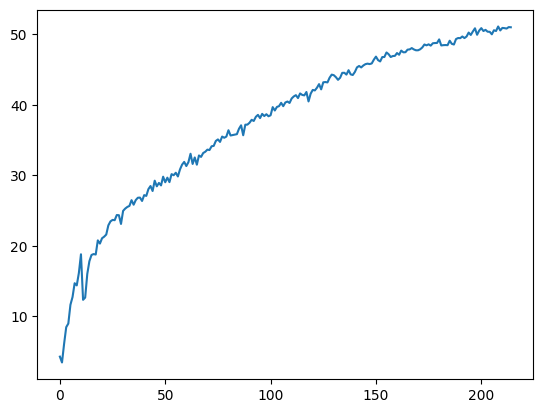

In [ ]:
b=[4.27242690932994,3.4436769071890385,6.0983160332757596,8.4490498985563,8.964594471211337,11.625969250591433,12.728865501831988,14.687012045967336,14.379769527182287,16.12777724436351,18.792831131390162,12.331912454293699,12.653068900108337,16.011223306461257,17.809387304344956,18.69574498157112,18.82255153023467,18.75726942261871,20.766293003851054,20.311383605003357,21.06542693717139,21.28768864456488,21.5921412414434,22.90009876659938,23.456685434798803,23.67098948906879,23.628872338606385,24.35816083878887,24.33746142776645,23.094059440554403,24.949913467679703,25.2758433697175,25.50653898107762,25.654065329201366,26.471232023774363,25.824983141860184,26.481507160225693,26.81442998988288,26.834609746932983,26.355669914459696,27.186669057729294,27.074074805999288,28.030104284383814,28.475870477909943,27.76966577160115,29.235073554272553,28.43472819668906,28.913385225802053,28.563013497664002,29.799192122050695,29.00955767534217,29.66200498902068,29.028190940618515,30.16176901301559,30.008242254354517,30.358518571269755,29.833557087547923,30.82942499433245,31.513113960927846,31.896824496132986,31.310379076977167,31.85999654993719,33.0548549136337,31.606737538259857,32.52953462941306,31.502844012513453,32.81027120960002,32.608192344101106,33.15483659627486,33.34033698451762,33.636388827343374,33.58087606576024,34.117413418633596,34.16980469470121,34.865334469444896,35.08790488389074,34.73426169035386,35.49310271837273,35.32303288518166,35.48849977279196,36.38921309004024,35.64376339620473,35.71091858951413,35.78658633815999,35.831475977994955,36.60084129352959,37.089727634069874,35.67649485626999,37.17544386338214,37.18822526931763,37.451175593599984,37.86992527757372,37.70383059491917,38.293651571079174,38.571018418487235,38.11117222661875,38.71054741071195,38.40199331604705,38.66205709807727,38.374341906333456,38.50958716990996,39.66971815848837,39.19118798995505,39.6961964016058,39.80533331146046,40.2783866901787,39.805061924214264,40.32752542106473,40.46273797385547,40.25943177086966,40.897004589742544,41.186721110830504,41.365854769336934,40.95408932043581,41.612952003673634,41.40285919393812,41.335739179533356,41.813683305467876,40.47616253093798,41.5665813197895,42.106580409468435,42.03701805581852,42.416967640117726,42.93030654654211,42.19040185578015,43.187911257451894,43.22680154138682,43.17606357652314,43.8399530868141,44.27835615800352,44.198005301611765,43.9170937538147,43.53941588985677,43.83825005317221,44.52886430584655,44.5415482910312,44.279802127760284,44.90684213443678,44.315604239094014,44.22761649988136,44.6582752247246,45.30806503003957,45.50638083049229,45.299773255173044,45.57329643502527,45.762719480358825,45.83696650972172,45.77636771299401,45.86386921941018,46.40201627964876,46.83279078833911,46.337670963637684,46.1484989146797,46.77018615664268,46.777263310490824,47.4239046233041,47.179183113331696,46.77922301389733,46.914844201535594,46.94055266769565,47.340268485400145,47.09533596525387,47.6899929338572,47.44550964783649,47.45836889500521,47.822967675267435,47.858871090168854,48.04503409716548,47.852960810369375,47.730559222552245,47.732690762500376,47.87507695567851,48.1340317823449,48.55482205566095,48.433776553796264,48.574621852563354,48.39364179786371,48.72816142257379,48.759588183188924,48.77305379692389,49.27657052448818,48.41878240935657,48.46036165587756,48.47630086237071,48.456542769256906,49.09080882948272,48.64582356628107,48.549526993109254,49.32546300304179,49.47094479385687,49.452959683476664,49.690418997589425,49.464695687196695,49.685517534917714,50.242561233286956,49.90845462254116,50.404162718325246,50.85188632108727,49.93314483214398,50.525087288447786,50.8771737838278,50.46415675416284,50.63112280320148,50.36747520797107,50.352356589570334,49.999610414310375,50.57621299004068,50.46606007400824,51.109634740012034,50.54818138784292,50.903614219354125,50.8739607966676,50.81281960740381,51.020094584445566,50.997339345970936]
import matplotlib.pyplot as plt

plt.plot(range(len(b)), b)

In [ ]:
import torch

# 输入有向图的 edge_index 和 edge_rel
edge_index = torch.tensor([[0, 1, 2],  # 源节点
                           [1, 2, 0]])  # 目标节点
edge_rel = torch.tensor([0, 1, 2])  # 对应的关系 ID

# 添加反向边
reverse_edge_index = edge_index.flip(0)  # 反向边 [target, source]
reverse_edge_rel = edge_rel + edge_rel.max() + 1  # 给反向边分配新的关系 ID

# 合并原始边和反向边
new_edge_index = torch.cat([edge_index, reverse_edge_index], dim=1)
new_edge_rel = torch.cat([edge_rel, reverse_edge_rel], dim=0)

# 去重（如果需要，避免重复边）
new_edge_index, unique_indices = torch.unique(new_edge_index, dim=1, return_inverse=True)
new_edge_rel = new_edge_rel[unique_indices]

# 输出无向图的 edge_index 和 edge_rel
print("New Edge Index:\n", new_edge_index)
print("New Edge Rel:\n", new_edge_rel)

New Edge Index:
 tensor([[0, 0, 1, 1, 2, 2],
        [1, 2, 0, 2, 0, 1]])
New Edge Rel:
 tensor([0, 3, 4, 2, 5, 1])


In [ ]:
edge_index.shape

torch.Size([2, 3])

In [41]:
import os
import argparse
import gc
import torch
from tqdm import tqdm
from rdkit import Chem
import numpy as np
import json
import copy
from utils import *
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
from model.predictor import Predictor
from model.sampler import Sampler
from torch_geometric.utils import degree
from torch.utils.data.distributed import DistributedSampler
from data_process import smile_to_graph, read_smiles, read_interactions, generate_node_subgraphs, read_network
from sklearn.model_selection import StratifiedKFold, KFold
from train_eval import train, test, eval
import random
from main import *
import pdb
import sys

parser = argparse.ArgumentParser(description='TIGER')
args, unknown = parser.parse_known_args()

args.model_name = 'TIGER'
args.dataset = 'drugbank'
args.folds = 5
args.layer = 1
args.predictor_lr = 0.001
args.sampler_lr = 0.1
args.weight_decay = 0.0001
args.batch_size = 128
args.epoch = 50
# args.extractor = 'khop-subtree'
args.extractor = 'RL'
args.graph_fixed_num = 1
args.khop = 1
args.fixed_num = 32
args.d_dim = 64
args.fixed_num = 32
args.num_heads = 4
args.max_smiles_degree = 300
args.max_graph_degree = 600
args.dropout = 0.2
args.k_step = 10
args.sub_coeff = 0.1
args.mi_coeff = 0.1
args.s_type = 'random'
args.pos = 1
args.neg = 1

In [42]:
data, labels, smile_graph, node_graph, dataset_statistics, adj_matrix, edge_rel = load_data(args)

edge_index = torch.tensor(adj_matrix).T.cuda()
edge_rel = torch.tensor(edge_rel).cuda()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

setup_seed(42)

tmp = list(zip(*split_fold(5, data, labels, args.s_type)))
train_idx, test_idx, val_idx = tmp[0]

# train_idx = train_idx.numpy()

train_data = DTADataset(x=data[train_idx], y=labels[train_idx], sub_graph=node_graph, smile_graph=smile_graph)
test_data = DTADataset(x=data[test_idx], y=labels[test_idx], sub_graph=node_graph, smile_graph=smile_graph)
eval_data = DTADataset(x=data[val_idx], y=labels[val_idx], sub_graph=node_graph, smile_graph=smile_graph)

# train_loader = torch.utils.data.DataLoader(train_data, batch_size=args.batch_size, shuffle=False, collate_fn=collate) 
train_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=False, collate_fn=collate) 
test_loader = torch.utils.data.DataLoader(test_data, batch_size=args.batch_size, shuffle=False, collate_fn=collate) 
eval_loader = torch.utils.data.DataLoader(eval_data, batch_size=args.batch_size, shuffle=False, collate_fn=collate) 

DDI_predictor, DDI_sampler, predictor_optim, sampler_optim = init_model(args, dataset_statistics)
DDI_predictor.to(device)
DDI_sampler.to(device)
DDI_predictor.reset_parameters()

# DDI_predictor.load_state_dict(torch.load('/home/xiejc/Code/TIGER/RL/best_save/tiger/drugbank/RL/fold_0/0.00000/DDI_predictor.pt'))
# DDI_predictor.load_state_dict(torch.load('/home/xiejc/Code/TIGER/RL/best_save/tiger/drugbank/RL/1.0-1.0-s2/fold_0/67.35455/DDI_predictor.pt'))
DDI_predictor.load_state_dict(torch.load('/home/xiejc/Code/TIGER/RL/best_save/tiger/drugbank/khop-subtree/fold_0/0.87003/DDI_predictor.pt'))
# DDI_sampler.load_state_dict(torch.load('/home/xiejc/Code/TIGER/RL/best_save/tiger/drugbank/RL/1.0-1.0-s2/fold_0/67.35455/DDI_sampler.pt'))


Read /bigdat2/user/xiejc/zhangc/dataset/TIGER/dataset/drugbank/drug_smiles.txt!
load drug smiles graphs!!
load networks !!
load DDI samples!!
10630
10630
generate subgraphs!!
{'num_nodes': 391116, 'num_rel_mol': 133, 'num_rel_graph': 71, 'num_interactions': 20808, 'num_drugs_DDI': 1052, 'max_degree_graph': 7, 'max_degree_node': 69}


<All keys matched successfully>

In [43]:
import pickle

with open('/home/xiejc/Code/TIGER/RL/data/drugbank/khop-subtree/hop_1_old.pkl', 'rb') as f:
    h1 = pickle.load(f)

with open('/home/xiejc/Code/TIGER/RL/data/drugbank/khop-subtree/hop_1.pkl', 'rb') as f:
    h2 = pickle.load(f)


d1, d2 = data[0]




In [55]:
h1[(d1, d2)].x

tensor([    49,    819,   3906,  10879,  10886,  10887,  16113,  32172,  39877,
        101648, 161862, 161868, 161869, 161874, 161875, 161877, 161880, 161884,
        161885, 161894, 161899, 161903, 161906, 161907, 161911, 161912, 161913,
        161914, 161916, 161940,      9,     60,     84,    758,    759,    761,
           762,    763,    764,    767,    771,    772,    774,    776,    780,
           784,    786,    788,    789,    791,    793,    804,    830,    833,
           834,    835,    837,    839])

In [57]:
h2[(d1, d2)].x

tensor([     9,     49,     60,     84,    758,    759,    761,    762,    763,
           764,    767,    771,    772,    774,    776,    780,    784,    786,
           788,    789,    791,    793,    804,    819,    830,    833,    834,
           835,    837,    839,   3906,  10879,  10886,  10887,  16113,  32172,
         39877, 101648, 161862, 161868, 161869, 161874, 161875, 161877, 161880,
        161884, 161885, 161894, 161899, 161903, 161906, 161907, 161911, 161912,
        161913, 161914, 161916, 161940])

In [6]:
train_loaders = list(train_loader)

In [ ]:
s = []
for i in range(len(train_loaders)):
    data_subgraph = train_loaders[i][2]
    nodes_with_id_1 = torch.where(data_subgraph.id == 1)[0]

    neighbors = []
    for node in nodes_with_id_1:
        src_neighbors = data_subgraph.edge_index[1][data_subgraph.edge_index[0] == node]
        dst_neighbors = data_subgraph.edge_index[0][data_subgraph.edge_index[1] == node]
        node_neighbors = torch.cat([src_neighbors, dst_neighbors]).unique()
        neighbors.append(node_neighbors)
    print(data_subgraph.x)
    print(data_subgraph.edge_index)
    print(train_loaders[i][3])
    neighbors = torch.cat(neighbors).unique()
    print(neighbors)
    print(len(neighbors))
    asfdasf
    s.append(len(neighbors))

print(max(s), min(s))


In [4]:
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve, accuracy_score, auc
def get_score(label_all, prob_all):

    predicts_label = [1 if prob >= 0.5 else 0 for prob in prob_all]

    acc = accuracy_score(label_all, predicts_label)
    f1 = f1_score(label_all, predicts_label)
    auroc = roc_auc_score(label_all, prob_all)
    p, r, t = precision_recall_curve(label_all, prob_all)
    auprc = auc(r, p)

    return acc, f1, auroc, auprc

In [5]:
pred1 = []
label = []

total_reward = 0

num_nodes = dataset_statistics['num_nodes']

for data in tqdm(train_loader):
    data_mol1 = data[0].cuda()
    data_mol2 = data[1].cuda()
    data_subgraph = data[2].cuda()
    data_idx = data[3].cuda() 

    predicts, loss = DDI_predictor(data_mol1, data_mol2, data_subgraph)

    pred1.append(predicts)

    label.append(data_mol1.y)


label_all = torch.concat(label).cpu().detach().numpy()
pred1_all = torch.concat(pred1).cpu().detach().numpy()

acc1, f11, auc1, aupr1 = get_score(label_all, pred1_all)
print('Default Model: acc: %.4f, f1: %.4f, auroc: %.4f, auprc: %.4f' % (acc1, f11, auc1, aupr1))



100%|██████████| 98/98 [00:55<00:00,  1.78it/s]

Default Model: acc: 0.8804, f1: 0.8888, auroc: 0.9500, auprc: 0.9436


In [ ]:
pred1 = []
pred2 = []
label = []

total_reward = 0

num_nodes = dataset_statistics['num_nodes']

for data in tqdm(train_loader):
    data_mol1 = data[0].cuda()
    data_mol2 = data[1].cuda()
    data_subgraph = data[2].cuda()
    data_idx = data[3].cuda() 

    selected_subgraph_list, batch = DDI_sampler.generate_default_subgraph(data_idx, edge_index, edge_rel)
    selected_subgraph_list = selected_subgraph_list.cuda()
    batch = batch.cuda()
    pred_default = DDI_predictor.pred(data_mol1, data_mol2, data_subgraph, batch)

    pred1.append(pred_default)

    embeddings = DDI_predictor.drug_node_feature.node_encoder(torch.tensor(range(num_nodes)).cuda())
    selected_subgraph_list, batch = DDI_sampler.predict(data_idx, edge_index, edge_rel, embeddings) 
    selected_subgraph_list = selected_subgraph_list.cuda()
    batch = batch.cuda()
    
    reward_batch, predicts = DDI_predictor.get_reward(data_mol1, data_mol2, selected_subgraph_list, batch, pred_default)
    total_reward += torch.sum(reward_batch).item()

    pred2.append(predicts)
    label.append(data_mol1.y)


label_all = torch.concat(label).cpu().detach().numpy()
pred1_all = torch.concat(pred1).cpu().detach().numpy()
pred2_all = torch.concat(pred2).cpu().detach().numpy()

acc1, f11, auc1, aupr1 = get_score(label_all, pred1_all)
acc2, f12, auc2, aupr2 = get_score(label_all, pred2_all)
print('Default Model: acc: %.4f, f1: %.4f, auroc: %.4f, auprc: %.4f' % (acc1, f11, auc1, aupr1))
print('RL Model: acc: %.4f, f1: %.4f, auroc: %.4f, auprc: %.4f' % (acc2, f12, auc2, aupr2))



100%|██████████| 98/98 [12:38<00:00,  7.74s/it]

Default Model: acc: 0.5706, f1: 0.5940, auroc: 0.6051, auprc: 0.6070
RL Model: acc: 0.5990, f1: 0.6266, auroc: 0.6378, auprc: 0.6333


In [7]:
idx = 200

data_mol1 = train_loaders[idx][0].cuda()
data_mol2 = train_loaders[idx][1].cuda()
data_subgraph = train_loaders[idx][2].cuda()
data_idx = train_loaders[idx][3].cuda() # batch_size * 2

DDI_predictor.eval()
DDI_sampler.eval()

with torch.no_grad():
    batch = torch.tensor(range(data_idx.shape[0])).cuda()
    pred_default = DDI_predictor.pred(data_mol1, data_mol2, data_subgraph, batch)

print(pred_default, data_mol1.y)

tensor([0.9665], device='cuda:0') tensor([1], device='cuda:0')


In [39]:
src, tgt = data_subgraph.edge_index
src = src.cpu().detach().numpy().tolist()
tgt = tgt.cpu().detach().numpy().tolist()
b = list(zip(src, tgt))
print(len(b))
print(len(set(b)))

364
178


In [40]:
src, tgt = G_sub.edge_index
src = src.cpu().detach().numpy().tolist()
tgt = tgt.cpu().detach().numpy().tolist()
a = list(zip(src, tgt))
print(len(a))
print(len(set(a)))

242
238


In [25]:
from torch_geometric.utils import degree, subgraph, k_hop_subgraph

idx = 200

data_mol1 = train_loaders[idx][0].cuda()
data_mol2 = train_loaders[idx][1].cuda()
data_subgraph = train_loaders[idx][2].cuda()
data_idx = train_loaders[idx][3].cuda() # batch_size * 2

DDI_predictor.eval()
DDI_sampler.eval()

x = data_subgraph.x

edge_index2, edge_rel2 = subgraph(x, edge_index, edge_rel, relabel_nodes=True)

mapping_id = torch.zeros(len(x), dtype=torch.long)
mapping_id[torch.where(x == data_idx[0][0])[0]] = 1
mapping_id[torch.where(x == data_idx[0][1])[0]] = 1

G_sub = DATA.Data(x=x,
            edge_index=edge_index2,
            id=mapping_id,
            rel_index=edge_rel2,
            sp_edge_index=edge_index2,
            sp_value=torch.ones(edge_index2.size(1), dtype=torch.float),
            sp_edge_rel=edge_rel2
        )

G_sub = Batch.from_data_list([G_sub]).cuda()

with torch.no_grad():
    batch = torch.tensor(range(data_idx.shape[0])).cuda()
    pred_default = DDI_predictor.pred(data_mol1, data_mol2, G_sub, batch)

print(pred_default, data_mol1.y)

tensor([0.9059], device='cuda:0') tensor([1], device='cuda:0')


In [11]:
selected_subgraph_list.to_data_list()

[Data(x=[64], edge_index=[2, 246], id=[64], rel_index=[246], sp_edge_index=[2, 246], sp_value=[246], sp_edge_rel=[246]),
 Data(x=[65], edge_index=[2, 250], id=[65], rel_index=[250], sp_edge_index=[2, 250], sp_value=[250], sp_edge_rel=[250]),
 Data(x=[66], edge_index=[2, 254], id=[66], rel_index=[254], sp_edge_index=[2, 254], sp_value=[254], sp_edge_rel=[254]),
 Data(x=[67], edge_index=[2, 258], id=[67], rel_index=[258], sp_edge_index=[2, 258], sp_value=[258], sp_edge_rel=[258]),
 Data(x=[68], edge_index=[2, 262], id=[68], rel_index=[262], sp_edge_index=[2, 262], sp_value=[262], sp_edge_rel=[262]),
 Data(x=[69], edge_index=[2, 268], id=[69], rel_index=[268], sp_edge_index=[2, 268], sp_value=[268], sp_edge_rel=[268]),
 Data(x=[70], edge_index=[2, 272], id=[70], rel_index=[272], sp_edge_index=[2, 272], sp_value=[272], sp_edge_rel=[272]),
 Data(x=[71], edge_index=[2, 276], id=[71], rel_index=[276], sp_edge_index=[2, 276], sp_value=[276], sp_edge_rel=[276]),
 Data(x=[72], edge_index=[2, 280

In [9]:
num_nodes = dataset_statistics['num_nodes']
with torch.no_grad():
    embeddings = DDI_predictor.drug_node_feature.node_encoder(torch.tensor(range(num_nodes)).cuda())
selected_subgraph_list, selected_subgraph_prob_list, batch, tmp = DDI_sampler(data_idx, edge_index, edge_rel, embeddings, data_subgraph)

selected_subgraph_list = selected_subgraph_list.cuda()
batch = batch.cuda()

with torch.no_grad():
    reward_batch, predicts = DDI_predictor.get_reward(data_mol1, data_mol2, selected_subgraph_list, batch, pred_default)

a = [(tmp[i], selected_subgraph_prob_list[i].item(), reward_batch[i].item()) for i in range(len(tmp))]
print([f"({x[0]}, {x[1]:.4f}, {x[2]:.4f})" for x in a])
print(torch.sum(reward_batch).item())
print(predicts)

['((0, 27743), 0.0088, -0.9665)', '((0, 27668), 0.0079, -0.9664)', '((0, 27680), 0.0080, -0.9664)', '((0, 151057), 0.0083, -0.9664)', '((0, 151084), 0.0082, -0.9664)', '((0, 25412), 0.0092, -0.9664)', '((0, 151058), 0.0086, -0.9664)', '((0, 27692), 0.0090, -0.9664)', '((0, 27687), 0.0090, -0.9664)', '((0, 27858), 0.0088, -0.9664)']
-9.66413688659668
tensor([9.8239e-05, 1.0850e-04, 1.1072e-04, 1.1109e-04, 1.1802e-04, 1.3134e-04,
        1.2990e-04, 1.8765e-04, 1.9280e-04, 1.7292e-04], device='cuda:0')


In [19]:
a = torch.tensor([1,2,3,4,5])
b = torch.tensor([3,2,1,7,6])

c = torch.cat([a,b], dim=0)
c = torch.unique(c, dim=0)
c

tensor([1, 2, 3, 4, 5, 6, 7])

In [ ]:
from torch_geometric.utils import degree, subgraph, k_hop_subgraph

graph_embeddings = torch.concat((embeddings, DDI_sampler.done_embedding.weight), dim=0) 

current_nodes = data_idx[0]

for _ in range(1):
    current_neighbors = DDI_sampler.get_neighbors(current_nodes, edge_index) 
    mask = ~torch.isin(current_neighbors, current_nodes)
    current_neighbors = current_neighbors[mask]

    neighbors_embeddings =  graph_embeddings[current_neighbors]
    k_embeddings = graph_embeddings[current_nodes].mean(dim=0)

    logits = DDI_sampler.prior(k_embeddings.expand_as(neighbors_embeddings), neighbors_embeddings)

    print(neighbors_embeddings.shape)



torch.Size([213, 64])


In [ ]:
logits

tensor([1.0830e-10, 6.3097e-10, 2.0367e-10, 6.0915e-11, 2.9689e-09, 6.3208e-11,
        7.5545e-11, 9.1292e-04, 2.6761e-06, 5.5650e-11, 5.1834e-10, 2.8352e-10,
        1.3596e-09, 3.6235e-11, 2.6743e-10, 3.2621e-10, 3.9418e-11, 6.6574e-11,
        8.5086e-11, 7.7675e-11, 4.3505e-10, 7.8275e-09, 1.9513e-10, 4.6439e-10,
        6.1970e-11, 1.7582e-10, 1.8908e-08, 1.5779e-10, 8.2300e-11, 1.3202e-10,
        5.6626e-11, 2.6970e-10, 2.0408e-09, 2.5742e-10, 6.8789e-08, 4.3487e-10,
        2.2408e-10, 1.1551e-10, 5.9214e-11, 4.3066e-10, 7.2286e-11, 4.4758e-10,
        1.4138e-03, 1.5043e-07, 2.6613e-09, 3.6469e-10, 5.1665e-05, 2.0351e-10,
        7.3577e-11, 3.1566e-09, 2.4525e-10, 4.9033e-11, 2.2919e-08, 4.8477e-11,
        7.5948e-11, 1.4439e-10, 2.4066e-10, 1.7304e-10, 2.5364e-09, 3.8400e-09,
        5.4374e-11, 8.3430e-11, 2.4670e-10, 6.0068e-11, 8.0299e-11, 3.3665e-10,
        1.2282e-10, 1.8414e-10, 1.0142e-10, 1.7689e-10, 6.3985e-11, 1.7394e-10,
        1.3243e-10, 1.3957e-10, 9.5974e-

In [ ]:
e1 = k_embeddings.expand_as(neighbors_embeddings)
e2 = neighbors_embeddings

e3 = DDI_sampler.prior.fc1(torch.cat((e1, e2), dim=-1))
e = e1 + e3

e_l1 = DDI_sampler.prior.fc_layers[0](e)
e_l2 = DDI_sampler.prior.fc_layers[1](e_l1)
e_l3 = DDI_sampler.prior.fc_layers[2](e_l2)
e_l4 = DDI_sampler.prior.fc_layers[3](e_l3).squeeze()
e_l4[80]

tensor(10.9395, device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
DDI_sampler.prior.fc_layers[3].weight

Parameter containing:
tensor([[ 0.4100, -0.5864, -0.4886, -0.5318,  0.4054,  0.4538, -0.4167,  0.5638,
         -0.4315,  0.4092,  0.4140, -0.5129, -0.5220,  0.5087, -0.4700,  0.4654,
          0.5506, -0.3612,  0.4555,  0.3850,  0.4648, -0.4004, -0.4736, -0.5325,
          0.3799,  0.5322, -0.5124, -0.4700, -0.4387, -0.4650,  0.3855, -0.3797]],
       device='cuda:0', requires_grad=True)

In [ ]:
e_l3[80:82]

tensor([[ 0.9748, -0.4366, -0.6336, -0.6649,  0.9594,  0.9516, -0.4009,  0.4172,
         -0.3794,  0.9258,  0.6849, -0.7392, -0.5632,  0.9083, -0.8041,  0.6441,
          0.9533, -0.9631,  0.8250,  0.4897,  0.5320, -0.9417, -0.9602, -0.8695,
          0.9606,  0.4458, -0.9518, -0.8146, -0.9534, -0.3829,  0.9191, -0.9409],
        [-0.8228,  0.9628,  0.9647,  0.9706, -0.8601, -0.8854,  0.8317, -0.9705,
          0.9311, -0.8923, -0.9306,  0.5511,  0.9716, -0.8803,  0.7787, -0.9118,
         -0.7977,  0.5250, -0.5871, -0.9763, -0.9459,  0.7911,  0.8878,  0.7249,
         -0.7988, -0.9823,  0.7826,  0.9244,  0.2728,  0.9364, -0.4391,  0.4792]],
       device='cuda:0', grad_fn=<SliceBackward0>)

In [ ]:
import torch
reward_all = []
batch = torch.tensor([0,0,0,1,1,1,1,2,2])
reward_batch = torch.tensor([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
for b in torch.unique(batch):
    idx = (batch == b).nonzero(as_tuple=True)[0]
    batch_reward = reward_batch[idx]
    reward = torch.zeros(batch_reward.size(), device=batch_reward.device)
    R = 0
    n = batch_reward.size(0) - 1
    for i, r in enumerate(batch_reward.flip(0)):
        R = r + 1 * R
        reward[n-i] = R
    reward_all.append(reward)
reward_batch = torch.concat(reward_all)

print(reward_batch)

tensor([0.6000, 0.5000, 0.3000, 2.2000, 1.8000, 1.3000, 0.7000, 1.7000, 0.9000])
